In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
#import dask.dataframe as dd
from xhistogram.xarray import histogram

import geopandas as gpd

%matplotlib inline
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5241434.datarmor0/parcels-502090/libparcels_random_821076ba-e545-467c-94a4-bba29bc57215.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)

client = Client(cluster)

In [4]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])

In [5]:
df_Lspectra_mean0 = p.load_diagnostic('spectra_raw_uv_mean0').persist()
df_Lspectra_mean1 = p.load_diagnostic('spectra_raw_uv_mean1').persist()
df_Lspectra_mean2 = p.load_diagnostic('spectra_raw_uv_mean2').persist()

In [23]:
ds_mean0 = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60.zarr'))
ds_mean0 = ds_mean0.where(ds_mean0.Depth>500,drop=False)
ds_mean0['lon'] = 0*ds_mean0.face+ds_mean0.XC
ds_mean0['lat'] = 0*ds_mean0.face+ds_mean0.YC
print(ds_mean0)
print('\n data size: %.1f GB'%(ds_mean0.nbytes/1e9))

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 48, 72, 1440), meta=np.ndarray>
    lon        (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    lat        (face, j, i) float64 dask.array<ch

In [25]:
ds_mean1 = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60.zarr'))
ds_mean1 = ds_mean1.where(ds_mean1.Depth>500,drop=False)
ds_mean1['lon'] = 0*ds_mean1.face+ds_mean1.XC
ds_mean1['lat'] = 0*ds_mean1.face+ds_mean1.YC
print(ds_mean1)
print('\n data size: %.1f GB'%(ds_mean1.nbytes/1e9))

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 1080, j: 1080)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 48, 72, 1440), meta=np.ndarray>
    lon        (face, j, i) float64 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    lat        (face, j, i) float64 dask.array<ch

### Global spectra : 

In [6]:
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-90., 90., dl)

In [7]:
for ds_Lspectra in [df_Lspectra_mean0,df_Lspectra_mean1,df_Lspectra_mean2]:
    ds_Lspectra['lon'] = (ds_Lspectra['lon']+180)%360 - 180
    ds_Lspectra['lon_cut'] = ds_Lspectra['lon'].map_partitions(pd.cut, lon)
    ds_Lspectra['lat_cut'] = ds_Lspectra['lat'].map_partitions(pd.cut, lat)
    ds_Lspectra = ds_Lspectra.persist()

In [8]:
# Binning and averaging
uv_mean0 = df_Lspectra_mean0.groupby(['lat_cut']).mean().compute()
uv_mean1 = df_Lspectra_mean1.groupby(['lat_cut']).mean().compute()
uv_mean2 = df_Lspectra_mean2.groupby(['lat_cut']).mean().compute()

In [9]:
_ds = pd.melt(uv_mean0.set_index(uv_mean0.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

In [10]:
ds = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv'}
               ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()

In [11]:
_ds = pd.melt(uv_mean1.set_index(uv_mean1.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

In [12]:
ds['uv_mean1'] = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv_mean1'}
                           ).to_xarray().set_index(index=['lat_bins','frequency']).unstack().uv_mean1

In [13]:
_ds = pd.melt(uv_mean2.set_index(uv_mean2.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

In [14]:
ds['uv_mean2'] = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv_mean2'}
                           ).to_xarray().set_index(index=['lat_bins','frequency']).unstack().uv_mean2

In [28]:
ds_mean0.SSUV

<xarray.DataArray 'SSUV' (face: 13, j: 1080, i: 1080, freq_time: 1440)>
dask.array<where, shape=(13, 1080, 1080, 1440), dtype=float64, chunksize=(1, 48, 72, 1440), chunktype=numpy.ndarray>
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
  * j          (j) int64 0 4 8 12 16 20 24 ... 4296 4300 4304 4308 4312 4316
    mask       (face, j, i) bool dask.array<chunksize=(1, 1080, 1080), meta=np.ndarray>

In [29]:
MKE = histogram(ds_mean0.lon, ds_mean0.lat, 
                 bins=[lon, lat], 
                 weights= ds_mean0.SSUV,#(0.5*ds.mean_velocity_amplitude), 
                 dim=['i', 'j','face','freq_time'],
                 block_size=None
                )

AttributeError: 'list' object has no attribute 'map_blocks'

#### Plot

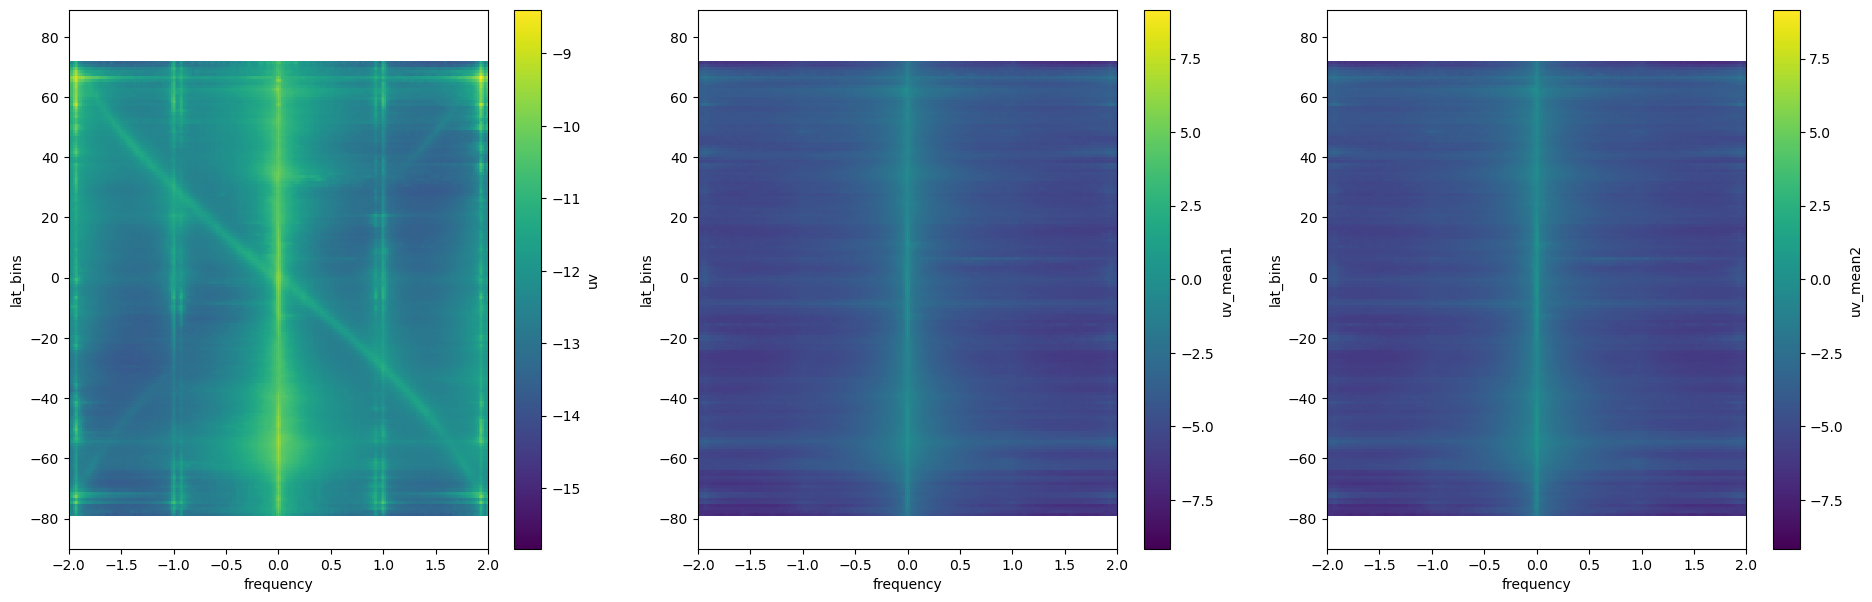

In [15]:
fig,axs = plt.subplots(1,3,figsize=(23,7))
for V,ax in zip(ds.keys(),axs):
    np.log10(ds[V]).plot(ax=ax,cmap='viridis')
    ax.set_xlim(-2,2)

### Sites of interest

In [17]:
def binned_spectra_site(bbox,df,dl):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    uv_sub = df_sub.groupby(['lat_cut']).mean().compute()
    _ds = pd.melt(uv_sub.set_index(uv_sub.index.map(lambda v: v.mid)
                                  ).drop(columns=['time','lon','lat']
                                        ).reset_index(),id_vars=['lat_cut'],var_name='frequency')

    _ds['frequency'] = _ds['frequency'].astype('float64')
    ds_sub = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv'}
                   ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
    return ds_sub

#### California : 

In [18]:
bbox = [-128, -123, 33, 38] # small bbox

In [19]:
dl = 1.

In [20]:
df_mean0_Cal = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_Cal = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_Cal = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('getitem-fb543f56dcec6895ea215f904dbc9321', 32)"


In [21]:
ds_Cal = xr.merge([df_mean0_Cal,df_mean1_Cal.uv.rename('uv_mean1')
                   ,df_mean2_Cal.uv.rename('uv_mean2')])

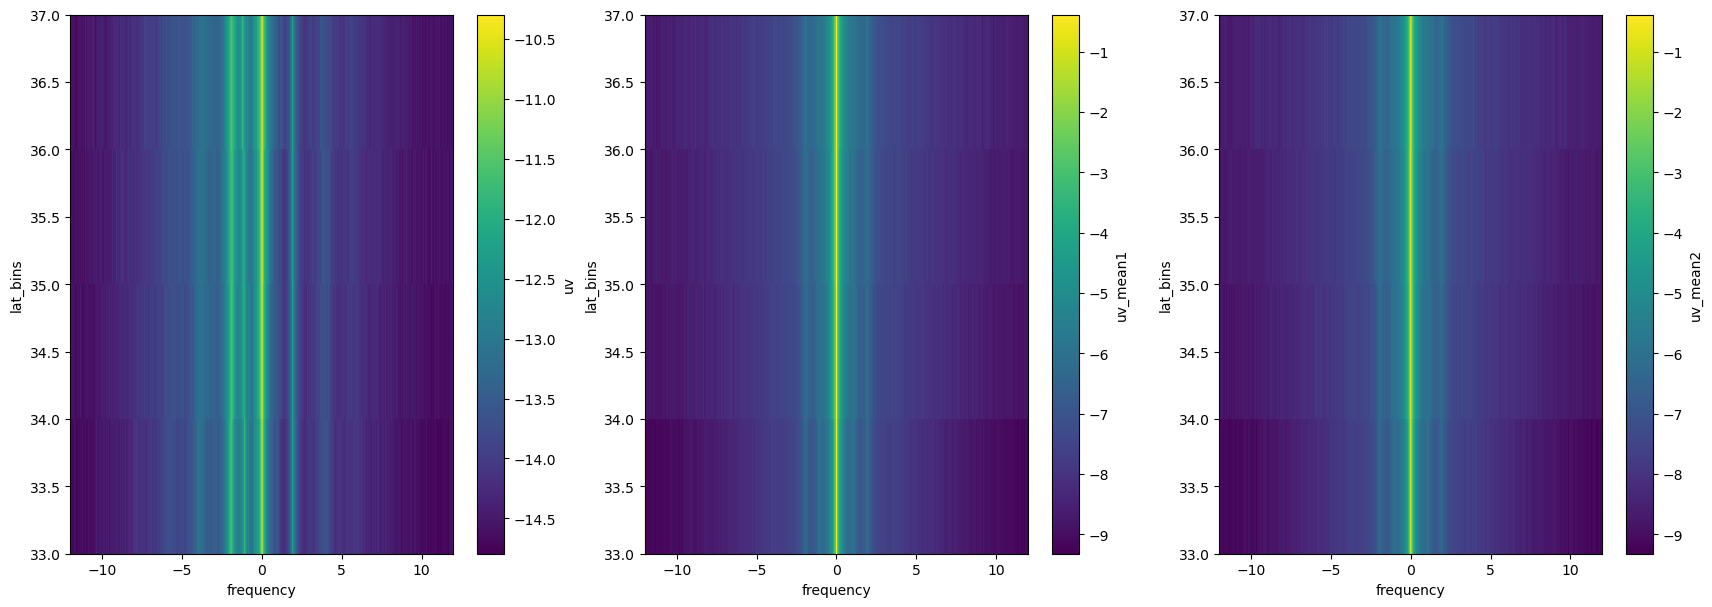

In [23]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).plot(ax=ax)

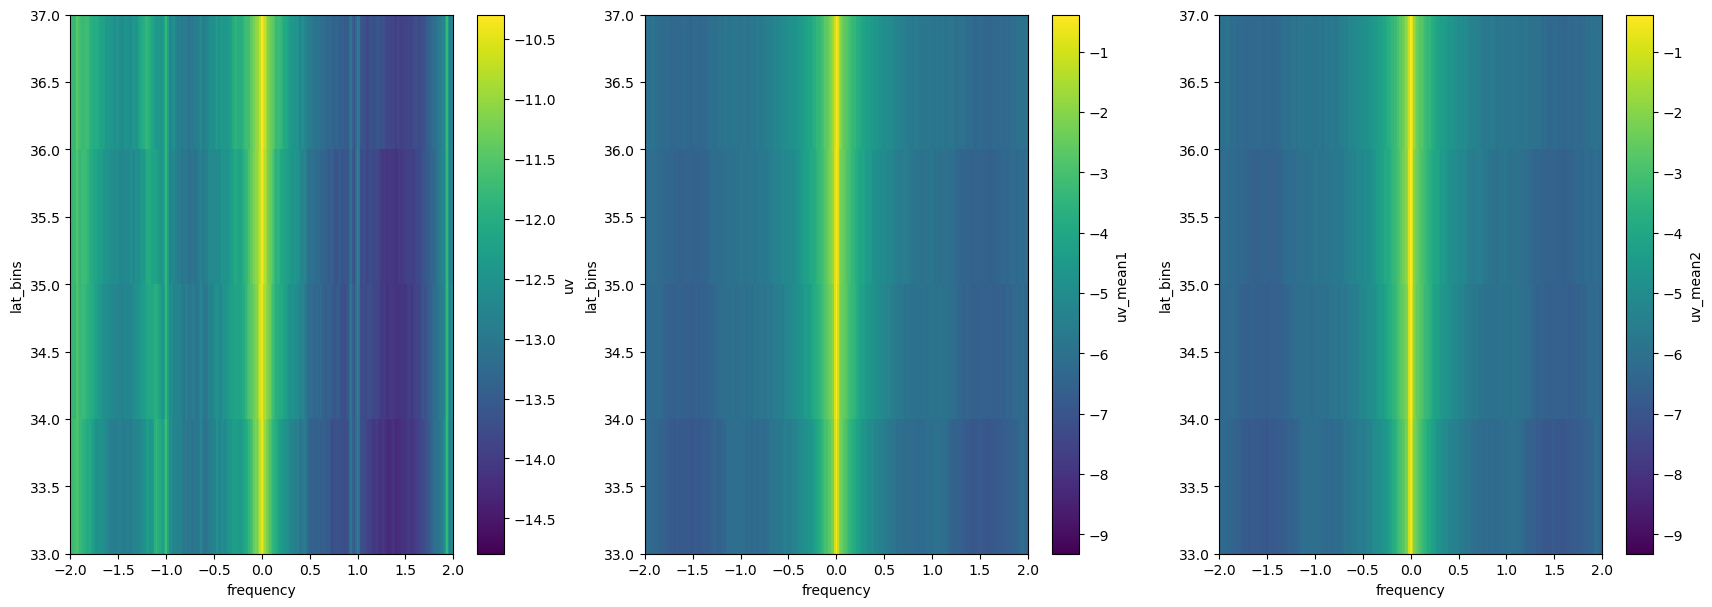

In [24]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).plot(ax=ax)
    ax.set_xlim(-2,2)

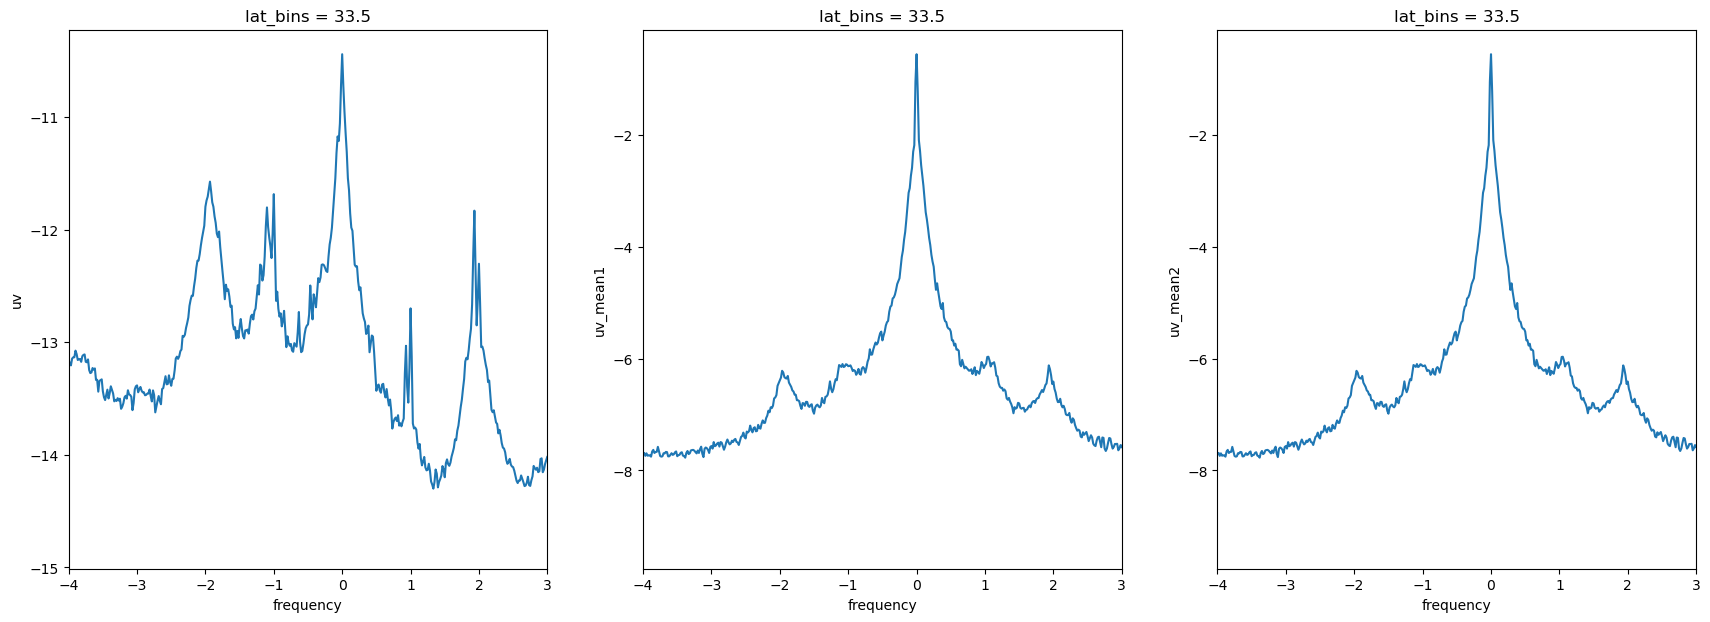

In [26]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).isel(lat_bins=0).plot(ax=ax)
    ax.set_xlim(-4,3)

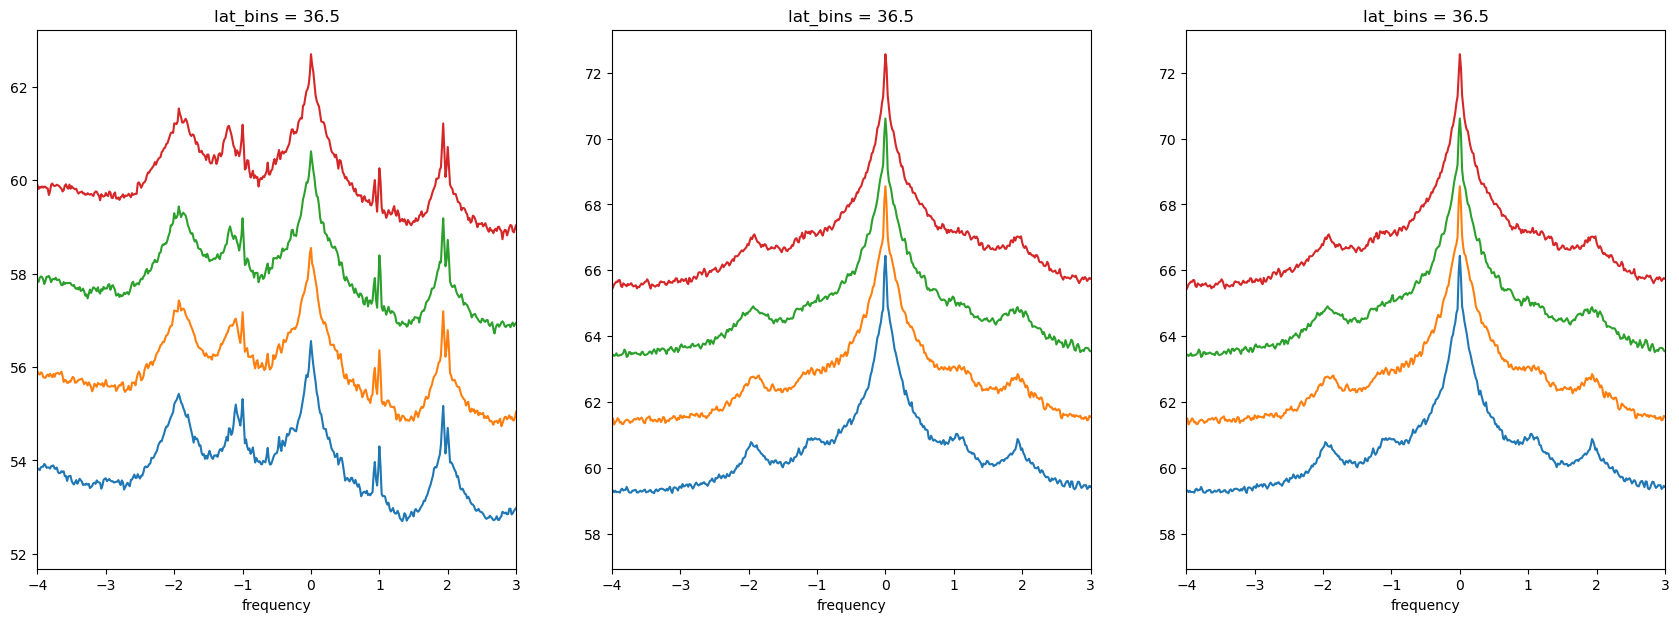

In [27]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    for i in ds_Cal.lat_bins:
        (np.log10(ds_Cal[V].sel(lat_bins=i))+2*i).plot(ax=ax)
        ax.set_xlim(-4,3)

#### Mediterranean sea

In [28]:
bbox = [-2, 8, 36, 45] # large bbox


In [29]:
df_mean0_Med = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_Med = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_Med = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

In [30]:
ds_Med = xr.merge([df_mean0_Med,df_mean1_Med.uv.rename('uv_mean1')
                   ,df_mean2_Med.uv.rename('uv_mean2')])

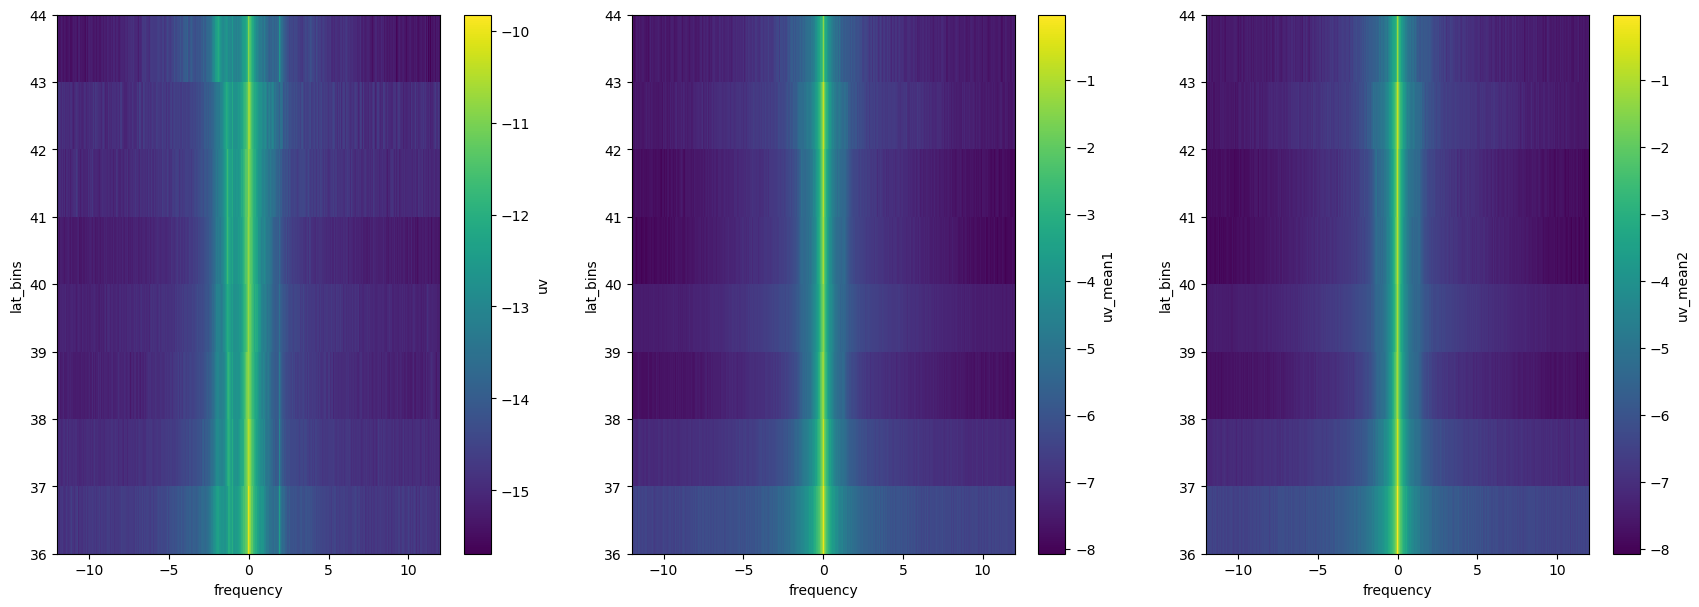

In [31]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    np.log10(ds_Med[V]).plot(ax=ax)

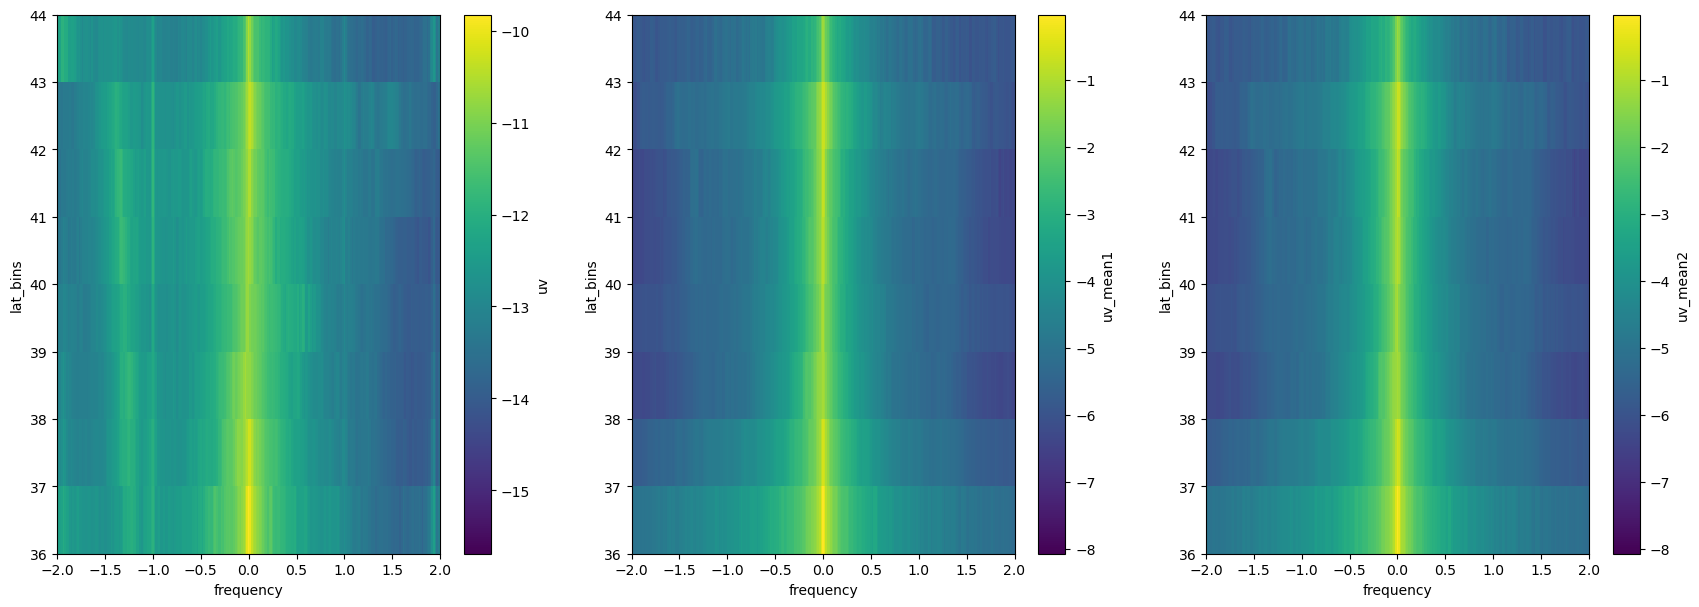

In [32]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    np.log10(ds_Med[V]).plot(ax=ax)
    ax.set_xlim(-2,2)

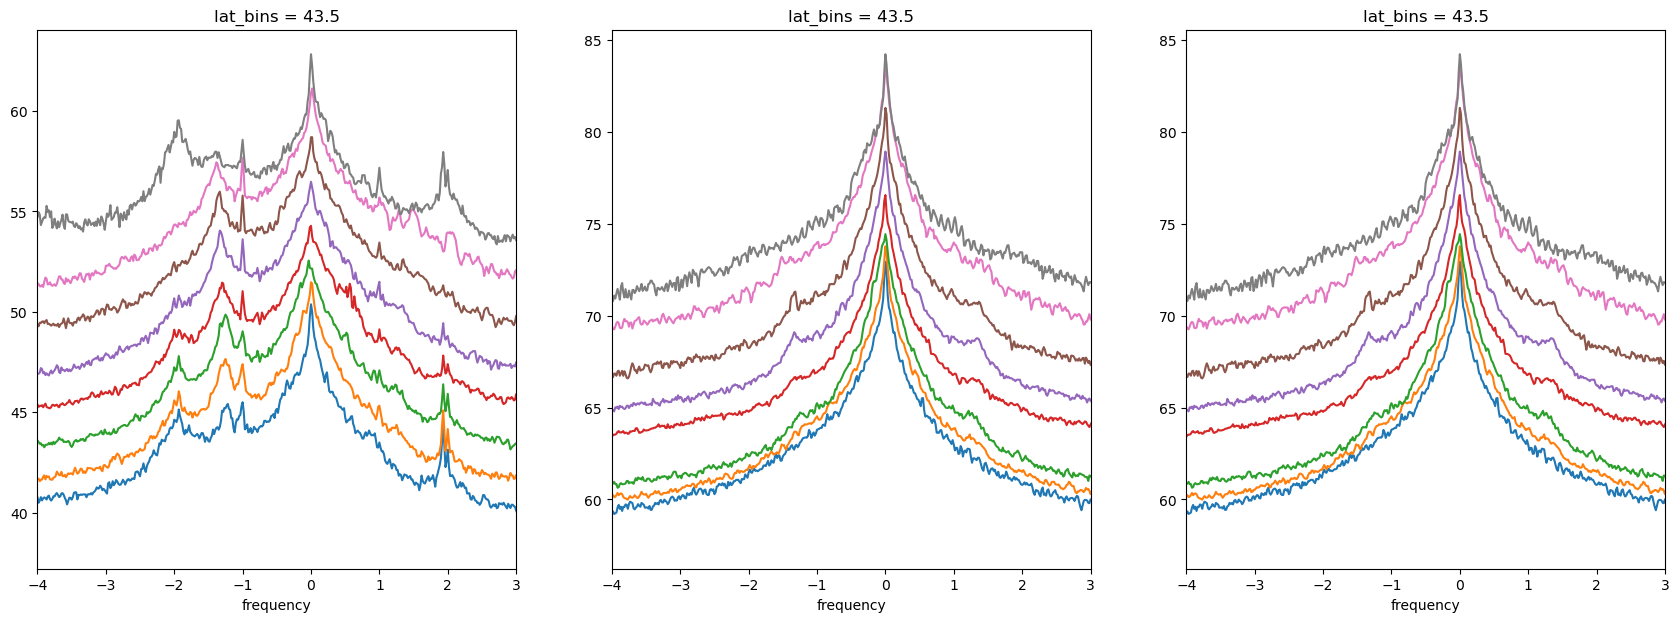

In [33]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    for i in ds_Med.lat_bins:
        (np.log(ds_Med[V].sel(lat_bins=i))+2*i).plot(ax=ax)
        ax.set_xlim(-4,3)

#### North west Australia

In [34]:
bbox = [120, 126, -20, -10]

In [35]:
df_mean0_NWA = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_NWA = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_NWA = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('getitem-b949495d75b0a64f61c751ba908107b1', 12)"
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar

In [36]:
ds_NWA = xr.merge([df_mean0_NWA,df_mean1_NWA.uv.rename('uv_mean1')
                   ,df_mean2_NWA.uv.rename('uv_mean2')])

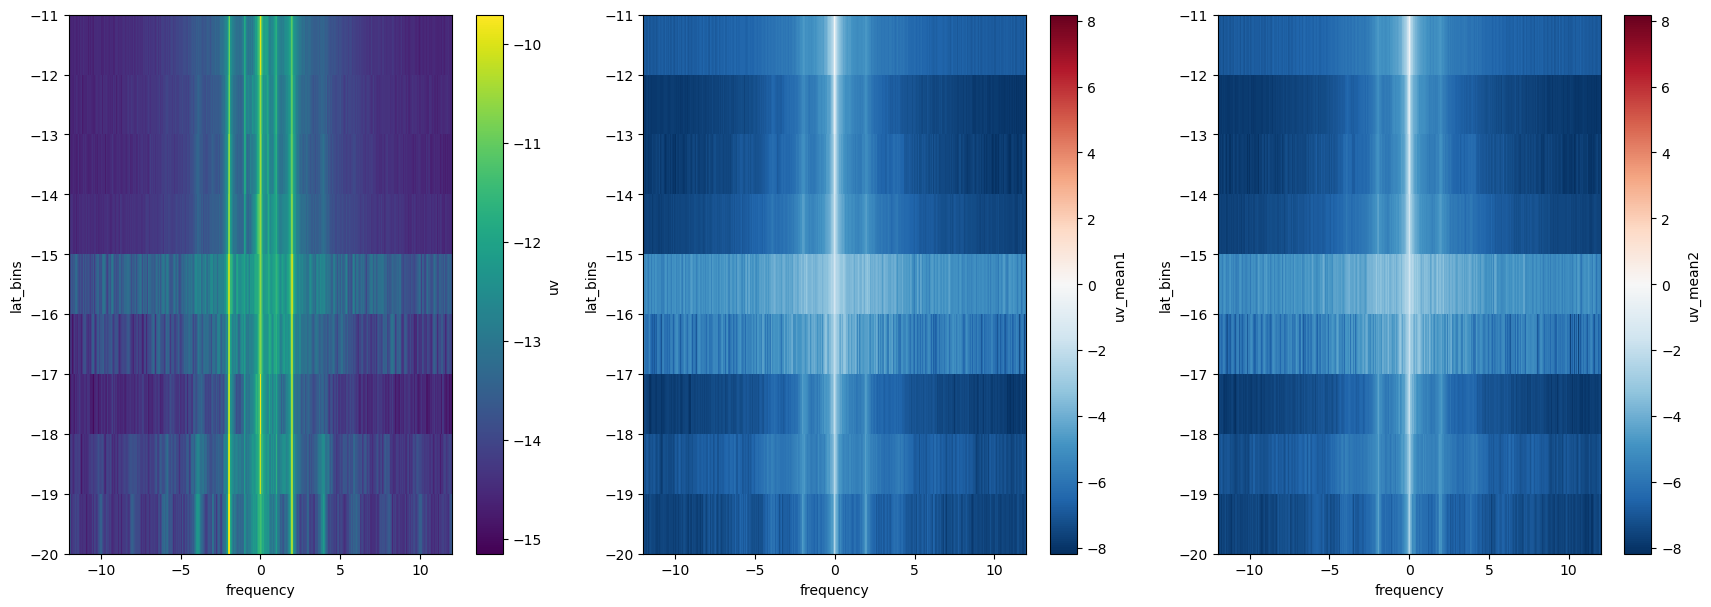

In [37]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    np.log10(ds_NWA[V]).plot(ax=ax)

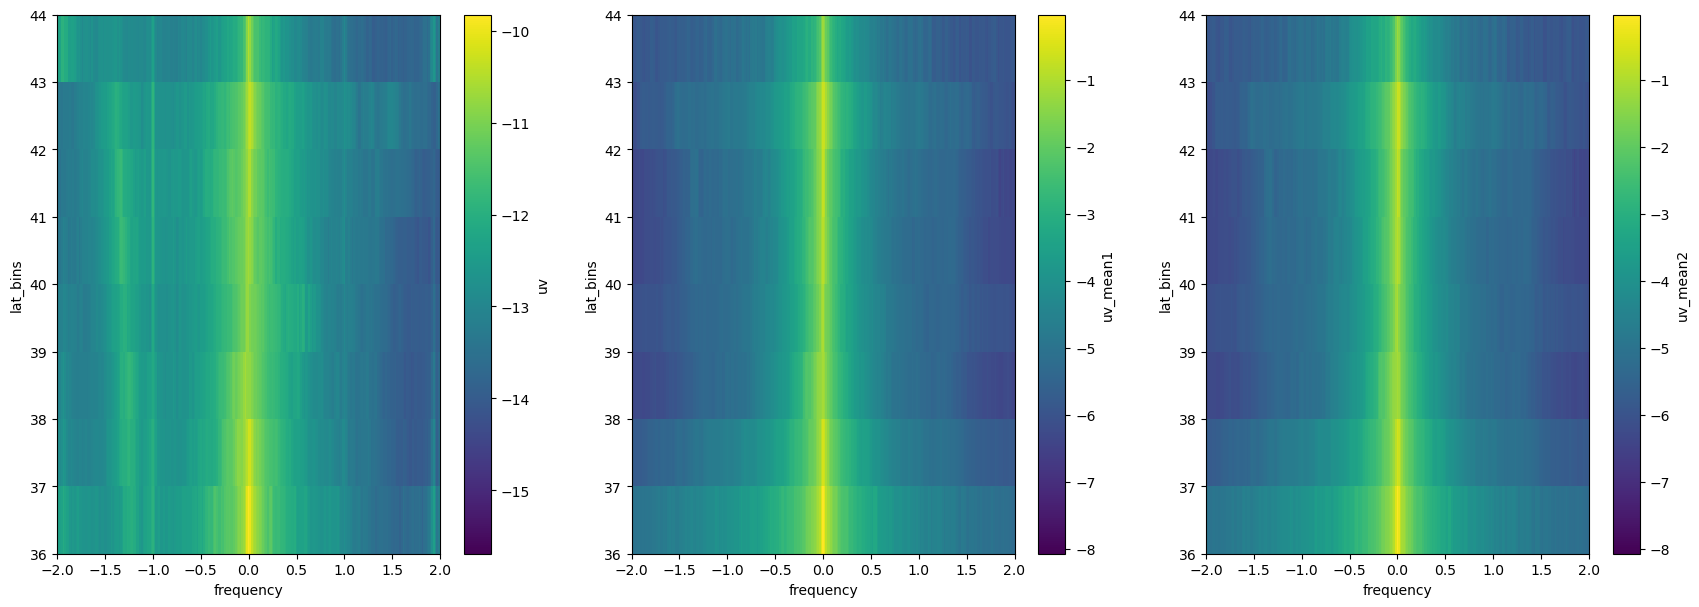

In [38]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    np.log10(ds_Med[V]).plot(ax=ax)
    ax.set_xlim(-2,2)

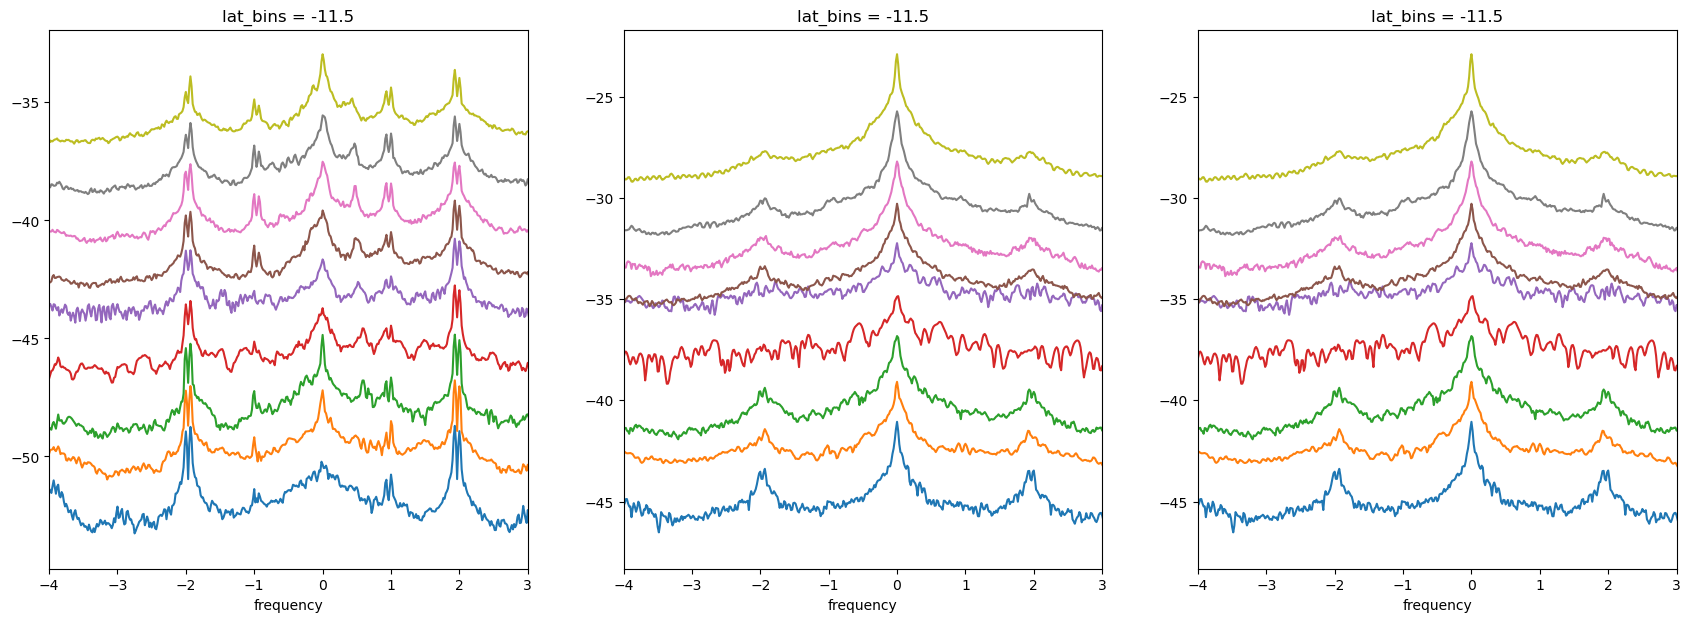

In [39]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    for i in ds_NWA.lat_bins:
        (np.log10(ds_NWA[V].sel(lat_bins=i))+2*i).plot(ax=ax)
        ax.set_xlim(-4,3)

In [40]:
cluster.close()